In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import statistics

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from numpy import sum as arraysum

print(tf.__version__)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.8.0


### Club all the traces together into a single dataframe

In [6]:
path = './traces/'# use your path
#all_files = glob.glob(path + "/*.h5")
all_files = glob.glob(path + "/dpotrf_T_*_N_20k-*.prof.h5")

li = []

for filename in all_files:
    trace =  pd.HDFStore(filename)
    data = trace.get('/events')
    trace.close()
    
    li.append(data)

df = pd.concat(li, axis=0, ignore_index=True)


# Clean the data

In [7]:
#remove info from other traces
df_refined = df[['begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority']].copy()
df_refined['exec_time'] = (df['end'] - df['begin']) * .001 #0.001 nano seconds to micro seconds
df_refined = df_refined.astype(float)

In [8]:
df_class_name = {0: 'dpotrf', 1: 'dtrsm', 2: 'dsyrk', 3: 'dgemm'}

In [9]:
filter = ( (df_refined['task_class_id'] == 3 )  )
#remove all other classes other than dpotrf, dgemm, trsm and syrk
df_refined = df_refined[filter]
df_refined.head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
8,185362563.0,227160705.0,4.0,3.0,0.0,3.0,15360000.0,396.0,41798.142
9,227198609.0,281851243.0,4.0,3.0,0.0,3.0,15360000.0,5038.0,54652.634
10,281900433.0,320213108.0,4.0,3.0,0.0,3.0,15360000.0,3519.0,38312.675
11,320251585.0,357250422.0,4.0,3.0,0.0,3.0,15360000.0,4330.0,36998.837
12,357297224.0,395973888.0,4.0,3.0,0.0,3.0,15360000.0,2292.0,38676.664


In [111]:
df_class = {}
for i in df_refined['task_class_id'].unique():
    df_class[i] = df_refined[df_refined['task_class_id'] == i]
    

### remove outliers

In [11]:

title = 'GEMM'
Q1 = df_refined['exec_time'].quantile(0.25)
Q3 = df_refined['exec_time'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range.
filter = (df_refined['exec_time'] >= Q1 - 1.5 * IQR) & (df_refined['exec_time'] <= Q3 + 1.5 *IQR)
df_refined = df_refined.loc[filter]
df_refined = df_refined.astype(float)
  

## integrate likelihood of the data being in cash.
we assume that all the task whose execution time is in the first quartile could have had all its data in the cache. While, the rest of the tasks would have resulted in a cache flush. While predicting we assume that the that the data of the task is not in the cache 

In [12]:
Q1 = df_refined['exec_time'].quantile(0.25)
Q3 = df_refined['exec_time'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range.
df_refined['cache_likelihood'] = np.where(df_refined['exec_time'] < Q1, 1, 0)

In [13]:
df_refined.tail()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time,cache_likelihood
1642692,3.939947e+11,3.939948e+11,4.0,3.0,0.0,3.0,240000.0,572.0,89.519,0
1642693,3.939976e+11,3.939977e+11,4.0,3.0,0.0,3.0,240000.0,103.0,108.031,0
1642695,3.940688e+11,3.940689e+11,4.0,3.0,0.0,3.0,240000.0,294.0,95.878,0
1642696,3.940694e+11,3.940695e+11,4.0,3.0,0.0,3.0,240000.0,288.0,98.266,0
1642702,3.941754e+11,3.941755e+11,4.0,3.0,0.0,3.0,240000.0,31.0,99.821,0


### Divide the data to training and test sets (GEMM)

In [15]:
train_dataset = df_refined.sample(frac=0.8, random_state=0)
test_dataset = df_refined.drop(train_dataset.index)
print(train_dataset.shape)
print(test_dataset.shape)

(1007640, 10)
(251910, 10)


## Divide the data into trainig features and labels

In [16]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('exec_time')
test_labels = test_features.pop('exec_time')

In [17]:
train_features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
begin,1007640.0,1.917908e+11,1.102670e+11,6.342351e+09,9.568582e+10,1.889181e+11,2.862502e+11,3.942089e+11
end,1007640.0,1.917909e+11,1.102670e+11,6.342465e+09,9.568591e+10,1.889182e+11,2.862503e+11,3.942091e+11
taskpool_id,1007640.0,4.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
task_class_id,1007640.0,3.000000e+00,0.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
chore_id,1007640.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
nb_data_items,1007640.0,3.000000e+00,0.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
total_data_size,1007640.0,2.400000e+05,0.000000e+00,2.400000e+05,2.400000e+05,2.400000e+05,2.400000e+05,2.400000e+05
priority,1007640.0,4.270159e+05,7.705201e+05,1.300000e+01,3.271900e+04,1.055560e+05,4.409012e+05,7.647749e+06
cache_likelihood,1007640.0,2.500476e-01,4.330404e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


# -------------------Build the multi variate full model------------------------------

## select the required features from the list

In [18]:
## for the time being select only total_data_size, priority, diff task_classes and diff taskpools

#train_features = train_features.drop('end', 1)
#train_features = train_features.drop('end', 1)
train_features = train_features.drop(['chore_id', 'begin', 'end', 'taskpool_id'], axis = 1)
test_features = test_features.drop(['chore_id', 'begin', 'end', 'taskpool_id'], axis = 1)
train_features.head()


,task_class_id,nb_data_items,total_data_size,priority,cache_likelihood
1142428,3.0,3.0,240000.0,454900.0,0
839879,3.0,3.0,240000.0,54278.0,0
1537092,3.0,3.0,240000.0,16376.0,0
1273068,3.0,3.0,240000.0,153335.0,0
1338292,3.0,3.0,240000.0,108361.0,0


In [19]:
normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer = layers.Normalization(input_shape=[1,], axis=None)
normalizer.adapt(np.array(train_features))

2022-04-13 12:53:48.181355: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:


full_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [21]:
full_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mse', metrics=[tf.keras.metrics.Accuracy()])
print(full_model.metrics_names)

[]


## Train the linear regression  model

In [22]:
history = full_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

In [35]:
train_features.head()

,task_class_id,nb_data_items,total_data_size,priority,cache_likelihood
1142428,3.0,3.0,240000.0,454900.0,0
839879,3.0,3.0,240000.0,54278.0,0
1537092,3.0,3.0,240000.0,16376.0,0
1273068,3.0,3.0,240000.0,153335.0,0
1338292,3.0,3.0,240000.0,108361.0,0


In [23]:
print(type(history))
print(history.history.keys())
print(type(history.history['loss']))
print(len(history.history['loss']))

<class 'keras.callbacks.History'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
<class 'list'>
100


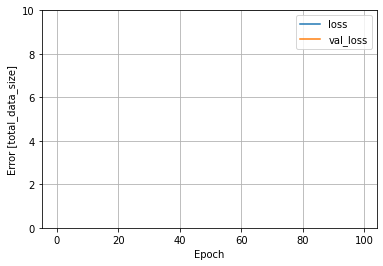

In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [total_data_size]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [25]:
full_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 17
Trainable params: 6
Non-trainable params: 11
_________________________________________________________________


In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,34.808182,0.000001,34.725075,0.0,95
96,34.799984,0.000001,34.741295,0.0,96
97,34.805130,0.000000,35.381222,0.0,97
98,34.809391,0.000000,34.861607,0.0,98
99,34.800987,0.000000,35.038837,0.0,99


## Test the Model 

In [27]:
#test_results = {}
#test_results['full_model'] = full_model.evaluate(
#    test_features, test_labels, verbose=0)
#loss, acc = full_model.evaluate(test_features, test_labels, verbose=2)
#print(test_results['full_model'])

loss = full_model.evaluate(test_features, test_labels, batch_size=128)
print(type(loss))
print(loss)

1969/1969 [==============================] - 3s 2ms/step - loss: 35.1341 - accuracy: 0.0000e+00
<class 'list'>
[35.134098052978516, 0.0]


## Train using DNN

In [28]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [29]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                384       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,620
Trainable params: 4,609
Non-trainable params: 11
_________________________________________________________________


In [30]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

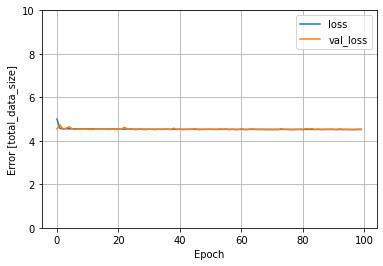

In [31]:
plot_loss(history)

## Test the model

In [32]:
loss = dnn_model.evaluate(test_features, test_labels, batch_size=128)
print(loss)

1969/1969 [==============================] - 4s 2ms/step - loss: 4.5401
4.540094375610352


## Predict

In [40]:
#task_class_id nb_data_items total_data_size priority cache_likelihood
print(dnn_model.predict([3, 3, 240000.0, 294.0, 0]))


[[96.8]]


In [46]:
dnn_model.save('./dnn_model_one_class')

2022-04-13 15:33:04.697942: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./dnn_model_one_class/assets


In [47]:
checkpoint_path = "./dnn_model_one_class.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [48]:
new_dnn_model = tf.keras.models.load_model('./dnn_model_one_class')

In [45]:
for layer in dnn_model.layers:
    print(layer.name, layer)
print(dnn_model.layers[0].weights)
print(dnn_model.layers[0].bias.numpy())
print(dnn_model.layers[0].bias_initializer)

normalization <keras.layers.preprocessing.normalization.Normalization object at 0x14ee897f0>
dense_1 <keras.layers.core.dense.Dense object at 0x14fdcbfd0>
dense_2 <keras.layers.core.dense.Dense object at 0x14fdcbe50>
dense_3 <keras.layers.core.dense.Dense object at 0x14fdcb8b0>
[<tf.Variable 'mean:0' shape=(5,) dtype=float32, numpy=
array([     3.  ,      3.  , 239999.14, 427015.53,      0.25],
      dtype=float32)>, <tf.Variable 'variance:0' shape=(5,) dtype=float32, numpy=
array([1.045e-10, 1.045e-10, 9.560e-01, 5.937e+11, 1.875e-01],
      dtype=float32)>, <tf.Variable 'count:0' shape=() dtype=int64, numpy=1007640>]


AttributeError: 'Normalization' object has no attribute 'bias'